In [ ]:
# загрузка библиотек
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# считывание данных. условия считывания - разделитель десятичных точка, разделитель столбцов запятая
s = pd.read_csv('4056_Nd данные для обучения.csv', squeeze=True)

In [ ]:
# индексирование по времени
s.index = pd.to_datetime(s.TimeValue, dayfirst=True)

In [ ]:
# перевод в серию интерполированную по 1 минуте
res = s.Value.resample('s').interpolate().resample('1T').asfreq().dropna()

In [ ]:
# создание обрабатываемого набора и именование
resedit = res.copy(deep=True)
resedit.name = 'target'

In [ ]:
# маска для заполнения null в 2019 году
mask1 = (resedit == 0) & (resedit.index < '2019-08-01')

In [ ]:
# значения 2020 и 2021 годов
year_2020 = resedit[(resedit.index >= resedit[mask1].index[0] + pd.offsets.DateOffset(years=1)) & (resedit.index <= resedit[mask1].index[-1] + pd.offsets.DateOffset(years=1))]
year_2021 = resedit[(resedit.index >= resedit[mask1].index[0] + pd.offsets.DateOffset(years=2)) & (resedit.index <= resedit[mask1].index[-1] + pd.offsets.DateOffset(years=2))]

In [ ]:
# вычисление значений для заполнения null в 2019 году
vals_to_fill_null = []
for i in range(len(year_2020)):
    vals_to_fill_null.append((year_2021[i] + year_2020[i]) / 2)

In [ ]:
# заполнение null значений в 2019 году
resedit[mask1] = vals_to_fill_null

In [ ]:
# замена выбросов средним значением
resedit[resedit <= 170] = resedit.mean()

In [ ]:
# создание и именование датафрейма скользящих окон
n=20
allres=[]

for i in range(300, 0, -n):
    res1=resedit.shift(periods=i)
    res1.name=f'Minus {i} minut'
    res2=resedit.shift(periods=i+1440)
    res2.name=f'Minus {i} minut prev_day'
    allres.append(res1)
    allres.append(res2)
for i in allres:
    resedit=pd.concat([resedit,i],axis=1)

# значение прошлого дня
prev_day = resedit.shift(periods=1440)['target']
prev_day.name = 'prev_day'
prev_prev_day = resedit.shift(periods=2880)['target']
# значение позапрошлого дня
prev_prev_day.name = 'prev_prev_day'
resedit = pd.concat([resedit, prev_day], axis=1)
resedit = pd.concat([resedit, prev_prev_day], axis=1)

In [ ]:
# создание дамми-параметров по месяцу и часу
resedit.insert(0, 'Year',(resedit.index).year)
resedit.insert(1, 'Month',(resedit.index).month)
resedit.insert(2, 'Hour',(resedit.index).hour)
resedit.insert(3, 'Minute',(resedit.index).minute)

In [ ]:
resedit.columns

Index(['Year', 'Month', 'Hour', 'Minute', 'target', 'Minus 300 minut',
       'Minus 300 minut prev_day', 'Minus 280 minut',
       'Minus 280 minut prev_day', 'Minus 260 minut',
       'Minus 260 minut prev_day', 'Minus 240 minut',
       'Minus 240 minut prev_day', 'Minus 220 minut',
       'Minus 220 minut prev_day', 'Minus 200 minut',
       'Minus 200 minut prev_day', 'Minus 180 minut',
       'Minus 180 minut prev_day', 'Minus 160 minut',
       'Minus 160 minut prev_day', 'Minus 140 minut',
       'Minus 140 minut prev_day', 'Minus 120 minut',
       'Minus 120 minut prev_day', 'Minus 100 minut',
       'Minus 100 minut prev_day', 'Minus 80 minut', 'Minus 80 minut prev_day',
       'Minus 60 minut', 'Minus 60 minut prev_day', 'Minus 40 minut',
       'Minus 40 minut prev_day', 'Minus 20 minut', 'Minus 20 minut prev_day',
       'prev_day', 'prev_prev_day'],
      dtype='object')

In [ ]:
resedit = resedit.dropna(axis=0)

In [ ]:
# массивы входов и целевой переменной для подачи в сеть
X = resedit.drop('target', axis=1)
y = resedit['target']

In [ ]:
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
X.shape, y.shape

((1276555, 36, 1), (1276555,))

In [ ]:
# модель нейросети

input_shape = X.shape[-2:]
print(f'Input shape: {input_shape}')


model = Sequential([
    LSTM(100, activation='tanh', input_shape=(X.shape[-2:]), return_sequences = True),
    LSTM(100, activation='tanh', input_shape=(X.shape[-2:]), return_sequences = True),
    LSTM(100, activation='tanh', input_shape=(X.shape[-2:])),
    Dense(1)
])

model.summary()

In [ ]:
# параметры обучения
earlystop = EarlyStopping(monitor='val_log_cosh', patience=20, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_log_cosh', factor=0.3, patience=10, verbose=1)
callbacks_list = [lr_reduce, earlystop]

In [ ]:
# компиляция модели
model.compile(loss='msle', optimizer=optimizers.Adam(learning_rate=1e-3), metrics=['log_cosh'])

In [ ]:
# обучение модели
history = model.fit(
        X, y, epochs=300, batch_size=1024, verbose=1,
        validation_split=0.15,
        callbacks = callbacks_list,
        shuffle = True
)

In [ ]:
# сохранение последних весов и загрузка лучших
model.save('model_lstm_msle_20_300_300prev_prevprev_1024.hdf5')

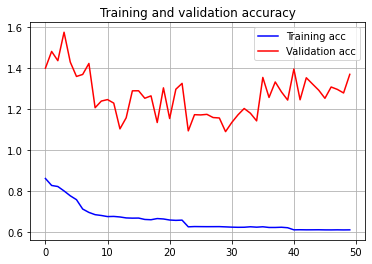

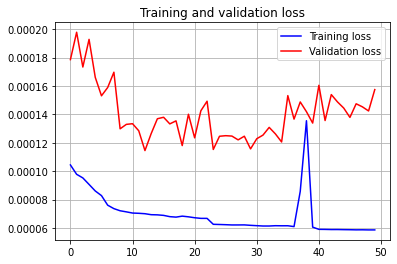

In [ ]:
  # графики обучения
  acc = history.history['log_cosh'][-50:]
  val_acc = history.history['val_log_cosh'][-50:]
  loss = history.history['loss'][-50:]
  val_loss = history.history['val_loss'][-50:]

  
  epochs = range(len(acc))

  plt.grid()
  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  
  plt.figure()

  plt.grid()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  
  plt.show()